## Otimizando o modelo GBC: GradientBoostingClassifier

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from warnings import simplefilter

from sklearn.ensemble import GradientBoostingClassifier

simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

plt.rcParams['figure.figsize'] = (25, 8)
#sns.set_style('whitegrid')
sns.set_style('white')
sns.set_context('poster')

In [50]:
df = pd.read_csv('datasets/dataset_cler.csv', sep=";", encoding='utf-16')
df.shape

(3458, 412)

In [51]:
df.drop(df.loc[(df['status']!='Loss') & (df['status']!='Gain')].index.values, inplace=True)
df['status'].value_counts()

Gain    2269
Loss    1189
Name: status, dtype: int64

In [52]:
X = df.drop(['take','status','oper'], axis=1) #df[train_features]
y = df['status']

x_columns = X.columns

In [53]:
encoder = LabelEncoder()
encoder.fit(['inside', 'up', 'down'])
columns_categorical = X.select_dtypes(include=['object']).columns
for col_cat in columns_categorical:
    X[col_cat] = encoder.transform(X[col_cat])

In [54]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

In [55]:
X[1]

array([0.05426357, 0.07512315, 0.08974359, 0.7778    , 0.06896552,
       0.24071065, 0.        , 0.        , 0.02892562, 0.03071672,
       1.        , 0.07      , 0.1209564 , 0.05952381, 0.5556    ,
       0.08333333, 0.3571199 , 0.01818182, 0.11964247, 0.0041841 ,
       0.00465116, 0.        , 0.13392857, 0.20648259, 0.12      ,
       0.5294    , 0.11627907, 0.32937619, 0.03061224, 0.19120355,
       0.07291667, 0.00952381, 1.        , 0.07462687, 0.10928962,
       0.02020202, 0.1667    , 0.18367347, 0.8       , 0.0212766 ,
       0.08970493, 0.01108033, 0.02093023, 0.        , 0.17045455,
       0.11542013, 0.10344828, 0.5294    , 0.01449275, 0.06247344,
       0.13461538, 0.44346328, 0.03846154, 0.05905512, 0.        ,
       0.02962963, 0.01430031, 0.03571429, 0.5       , 0.03571429,
       0.18184793, 0.03448276, 0.35552   , 0.02238806, 0.02164502,
       1.        , 0.06153846, 0.20354906, 0.1       , 0.6154    ,
       0.125     , 0.41417187, 0.        , 0.        , 0.04119

In [56]:
# Variáveis para coletar os resultados
models = np.array([])
opt_params = dict()
scores = np.array([])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=True)

In [58]:
gbc = GradientBoostingClassifier()
score = cross_val_score(gbc, X, y, cv=5)
score, score.mean()

(array([0.64017341, 0.6416185 , 0.6416185 , 0.63583815, 0.63913043]),
 0.6396757979391807)

## Otimizando o modelo GBC

In [59]:
def optimize(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, 
             max_features, subsample, params, cv = 5):
  np.random.seed(0)

  gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
    
  grid_search = GridSearchCV(estimator = gbc, param_grid = params, scoring = 'roc_auc',
                             n_jobs = -1, iid = False, cv = cv)
  grid_search.fit(X_train, y_train)
  results = grid_search.cv_results_
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_
  print(best_params, best_score)
  
  return gbc, best_params, best_score

def optimize2(n_estimators, learning_rate, min_samples_split, min_samples_leaf,
             max_depth, max_features, subsample, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  score = cv_scores.mean()

  plt.plot(np.append(scores, score))
  plt.title('n_estimators = {} / learning rate = {}'.format(n_estimators, learning_rate))
  
  return gbc, score

#### Otimizando: n_estimators para learning_rate = 0.1

In [60]:
# MODELO 0
learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 151, 10)}

In [61]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'n_estimators': 100} 0.507804877293405


In [62]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param} # ** para fundir um dict no outro
scores = np.append(scores, score)

#### Otimizando: max_depth e min_samples_split

In [63]:
# MODELO 1
n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

In [64]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 9, 'min_samples_split': 400} 0.5202240688929214


In [65]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

#### Otimizando: min_samples_leaf

In [66]:
# MODELO 2
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

In [67]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 55} 0.518538194431042


In [68]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

#### Otimizando: max_features

In [69]:
# MODELO 3
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

In [70]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 30} 0.5190239363714997


In [71]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [72]:
opt_params

{'n_estimators': 100,
 'max_depth': 9,
 'min_samples_split': 400,
 'min_samples_leaf': 55,
 'max_features': 30}

#### Otimizando: subsample

In [73]:
# MODELO 4
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

In [74]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.8000000000000002} 0.5190239363714997


In [75]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [76]:
opt_params

{'n_estimators': 100,
 'max_depth': 9,
 'min_samples_split': 400,
 'min_samples_leaf': 55,
 'max_features': 30,
 'subsample': 0.8000000000000002}

#### Otimizando: n_estimators e learning_rate

In [77]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [78]:
# MODELO 5
subsample = opt_params['subsample']

# 
learning_rate /= 2
n_estimators *= 2

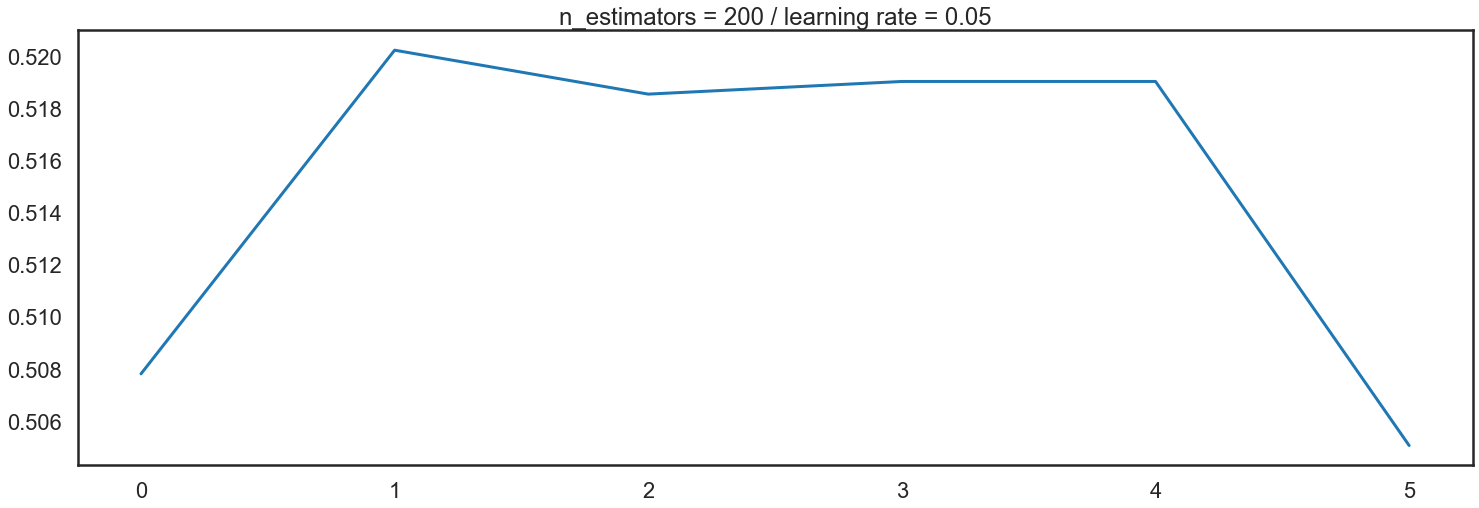

In [79]:
gbc, score = optimize2(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample)

In [80]:
score

0.505054902089649

In [81]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

#### Mais uma otimização na learning_rate e n_estimators

In [82]:
# MODELO 6
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.01, 1000)

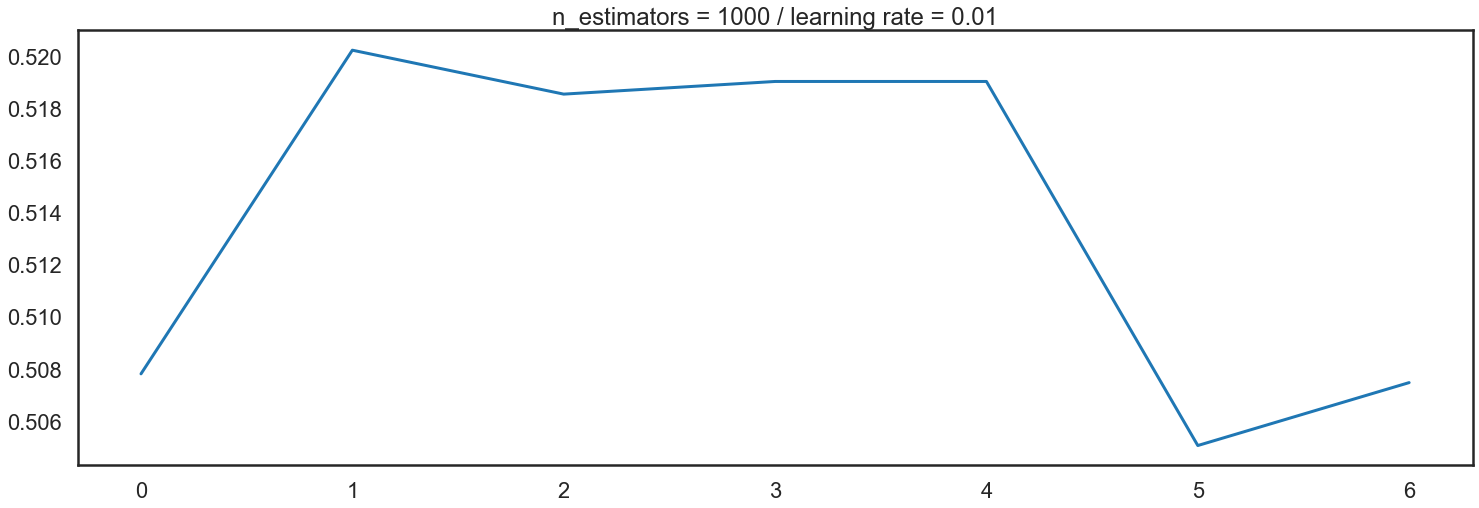

In [83]:
gbc, score = optimize2(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample)

In [84]:
score

0.5074697718953909

In [85]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

#### Mais uma otimização na learning_rate e n_estimators

In [86]:
# MODELO 7
learning_rate /= 2
n_estimators *= 2
learning_rate, n_estimators

(0.005, 2000)

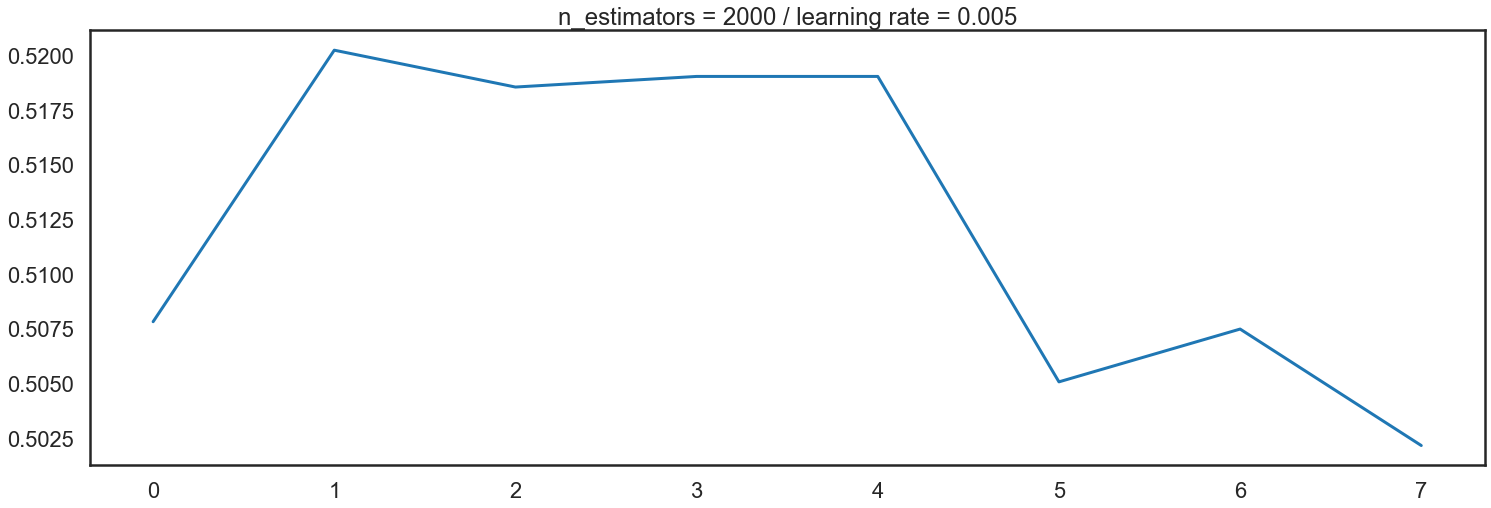

In [87]:
gbc, score = optimize2(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample)

In [88]:
score

0.5021429129920489

In [89]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

#### Mais uma otimização na learning_rate e n_estimators

In [90]:
# MODELO 8
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.001, 10000)

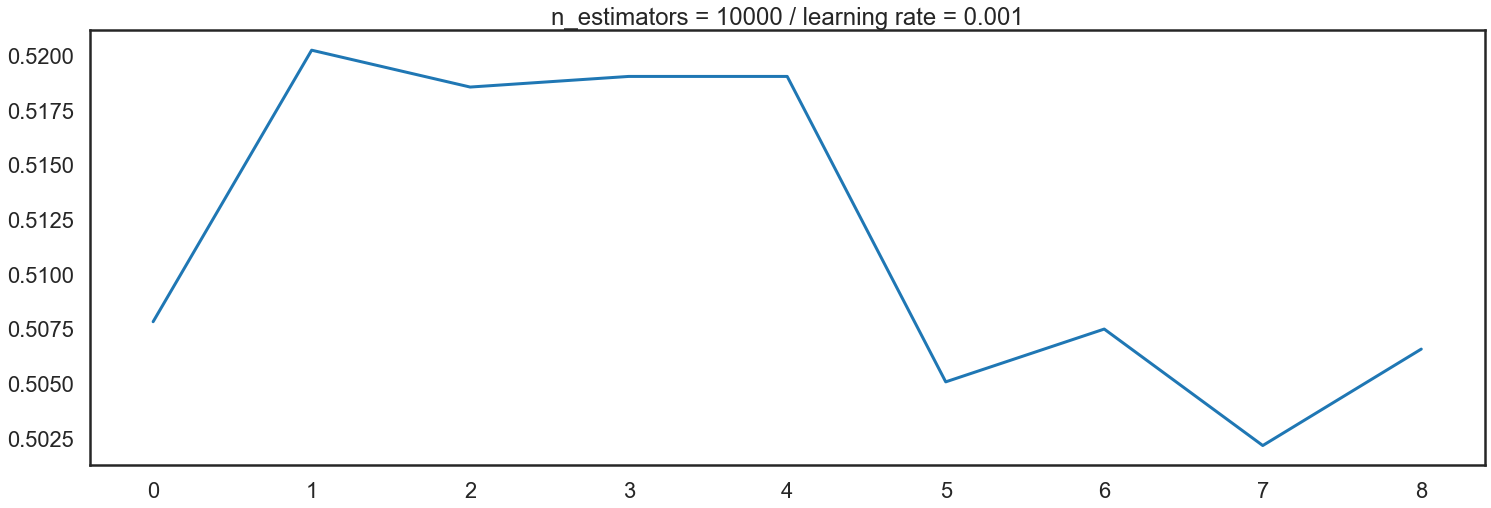

In [91]:
gbc, score = optimize2(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample)

In [92]:
score

0.5065546683713138

In [93]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [94]:
print('Melhor modelo: ', scores.argmax(), ' - AUC: ', max(scores))

Melhor modelo:  1  - AUC:  0.5202240688929214


## Best Model

In [50]:
best_model = models[scores.argmax()]

In [69]:
best_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=9,
                           max_features=27, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=25, min_samples_split=150,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [70]:
y_pred_probs = best_model.predict_proba(X_test)

In [71]:
y_pred = best_model.predict(X_test)

In [72]:
y_pred_probs[0:20,:]

array([[0.9597164 , 0.0402836 ],
       [0.92939983, 0.07060017],
       [0.82908906, 0.17091094],
       [0.01928006, 0.98071994],
       [0.91415561, 0.08584439],
       [0.92300162, 0.07699838],
       [0.80771216, 0.19228784],
       [0.2054    , 0.7946    ],
       [0.70021628, 0.29978372],
       [0.86719402, 0.13280598],
       [0.04101509, 0.95898491],
       [0.68388631, 0.31611369],
       [0.51501777, 0.48498223],
       [0.84555205, 0.15444795],
       [0.07129978, 0.92870022],
       [0.89630633, 0.10369367],
       [0.93718536, 0.06281464],
       [0.96588611, 0.03411389],
       [0.78665144, 0.21334856],
       [0.13385729, 0.86614271]])

In [73]:
y_pred[0:20]

array(['Gain', 'Gain', 'Gain', 'Loss', 'Gain', 'Gain', 'Gain', 'Loss',
       'Gain', 'Gain', 'Loss', 'Gain', 'Gain', 'Gain', 'Loss', 'Gain',
       'Gain', 'Gain', 'Gain', 'Loss'], dtype=object)

In [74]:
y_pred_probs[:, 1]

array([0.0402836 , 0.07060017, 0.17091094, ..., 0.43099373, 0.1862377 ,
       0.07139677])

In [75]:
# https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772
roc_auc_score(y_test, y_pred_probs[:, 1])

0.9203970229543252

In [76]:
accuracy_score(y_test, y_pred)

0.8709055876685935

#### Teste de previsão manual

In [77]:
index = 18
data = [X_test[(index-1)]]

print(best_model.predict_proba(data))
print(best_model.predict(data))
print(y_test[index-1:index])

[[0.96588611 0.03411389]]
['Gain']
517    Gain
Name: status, dtype: object


In [78]:
y_test.values

array(['Gain', 'Gain', 'Gain', ..., 'Loss', 'Gain', 'Gain'], dtype=object)

#### Save/Load Best Model

In [113]:
#https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pickle
filename = 'model_cler.sav'

In [114]:
# save the model to disk
pickle.dump(best_model, open(filename, 'wb'))

#exporting the departure encoder
output = open('LabelEncoder.pkl', 'wb')
pickle.dump(encoder, output)
output.close()

#exporting the departure encoder
output = open('MinMaxScaler.pkl', 'wb')
pickle.dump(scaler, output)
output.close()

## Evolução

In [76]:
# lista com todas as performance dos modelos criados
listScores = np.array([0.46, 0.53, 0.59, 0.63, 0.67, 0.8929108283977165, 0.8641101606535772,
                       0.8686614133161905, 0.8828589389246367, 0.8929108283977165, 0.9045952399425259, 0.9077300805283108, 0.9084626342390415, 0.9096680801776621])
listScores

array([0.46      , 0.53      , 0.59      , 0.63      , 0.67      ,
       0.89291083, 0.86411016, 0.86866141, 0.88285894, 0.89291083,
       0.90459524, 0.90773008, 0.90846263, 0.90966808])

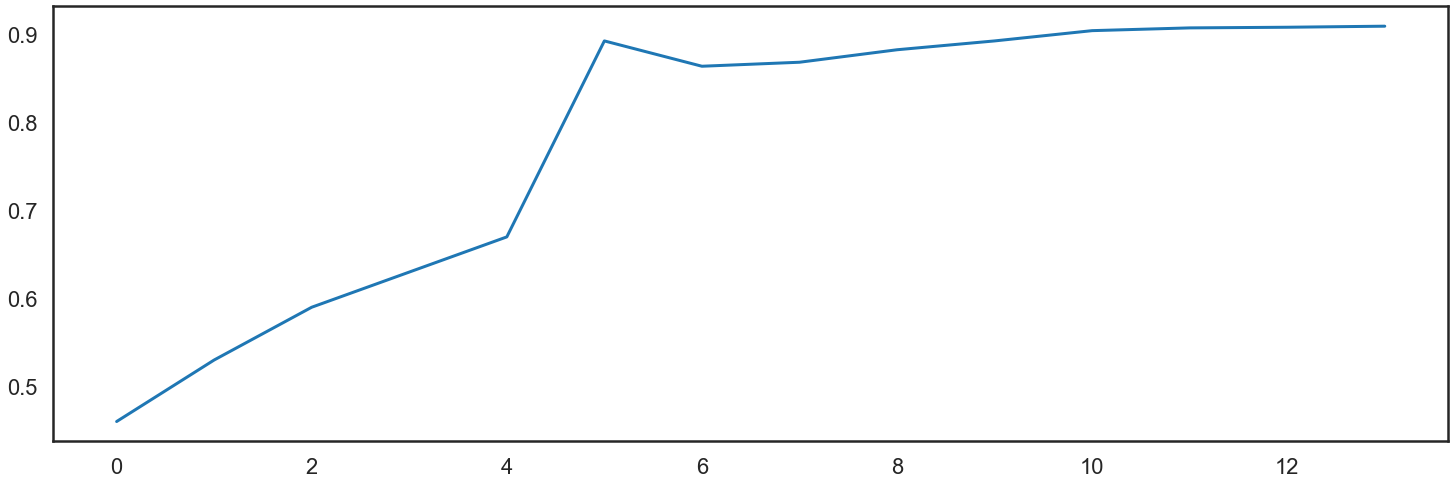

In [90]:
plt.plot(listScores)